# Air quality vs motorway traffic

Let's look at relationships between air quality and local motorway traffic.

The datasets in ./Data include:
- **indoor air quality data**: these are real and unmasked;
- **traffic data**: these are masked, and show "hour of week" vs traffic flow (data collected over one week at a time similar to indoor air quality monitoring);
- **outdoor air quality**: also masked, and show "hour of week" vs average outdoor CO2 and particulate matter (the averages were taken over a 6 month period that did not overlap with indoor air quality monitoring).

The data masking method used preserves correlations between data sets, but does not preserve absolute magnitudes.

In [144]:
from lib import airqual_read
from lib import plotter
from lib import constants
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# Several air quality sensors are placed at location 1b14, pick out sensor 0.
location = "1b14"
sensor = 0

The traffic data that we have is 1-hourly aggregated data.

We want indoor air quality data to match this, so we'll downsample it to a 1-hourly average (non-overlapping windows).

In [145]:
# Get the hourly averaged indoor air quality df
df = airqual_read.hourly_airqual(location,sensor)

# Read in the traffic flow data and outdoor air quality for this location and append to indoor air qual dataframe
traffic_df = pd.read_csv(constants.TRAFFIC_PATH / (location + "_traffic.csv"),index_col=0)
outdoor_df = pd.read_csv(constants.AIR_PATH / "outdoor" / (location + "_outair.csv"),index_col=0)

df = pd.concat([df,traffic_df,outdoor_df],axis=1)

# There are two motorways near this location. We'll aggregate the traffic flows.
df["M_count"] = df["M0_count"] + df["M1_count"]

At this point, our dataframe is full of various readings of temperature, humidity, noise, CO2, particulate matter, etc.

In [146]:
print(df)

          TEMP        HUM       BATT      LIGHT    NOISE_A      PRESS  \
0    16.264059  78.628954  99.928870   0.000000  35.952594  99.764686   
1    16.346485  79.248243  99.903766   0.000000  35.865021  99.771841   
2    16.500750  80.312111  99.925000   0.000000  34.076295  99.404556   
3    16.421972  80.741444  99.916667   0.000000  34.125278  99.400889   
4    16.395894  80.813212  99.932961   0.000000  34.196369  99.416229   
..         ...        ...        ...        ...        ...        ...   
163  15.943917  76.093222  99.961111   0.000000  29.808917  99.469083   
164  15.865487  76.350251  99.944290   0.000000  29.331838  99.461393   
165  15.912694  77.273917  99.947222  21.419444  31.211778  99.448139   
166  16.070724  78.309916  99.935933   5.880223  33.647437  99.437437   
167  16.189038  77.753180  99.907950   0.000000  36.959079  99.749289   

     CCS811_VOCS  CCS811_ECO2    SCD30_CO2  SCD30_TEMP  SCD30_HUM      PM_1  \
0    1327.418410  2039.280335  1875.799163  

We'll approach this naively and try and see which variables correlate strongly with each other. Here is a correlation heatmap:

<AxesSubplot: >

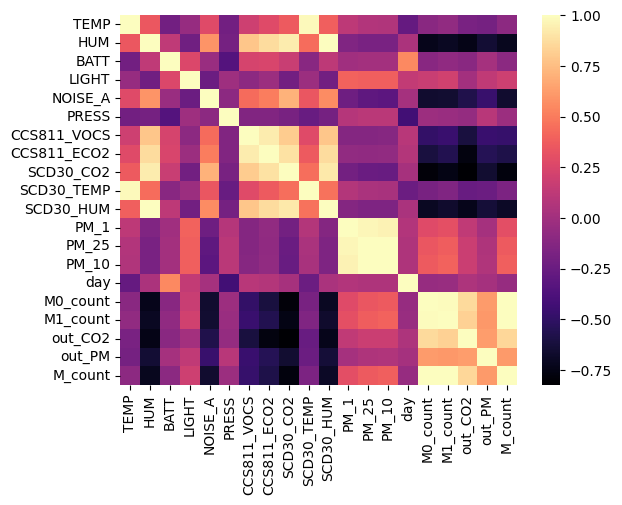

In [147]:
corr = df.corr()
sns.heatmap(corr, cmap="magma",annot=False)

The heatmap (and the correlation variables below) show that:
- outdoor CO2 (out_CO2) correlates strongly with motorway traffic (=0.85), and correlates well with outdoor PM (=0.6);
- indoor particulate matter (PM_1, P_25, PM_10) show weak correlations (0.4) with motorway traffic;
- of all indoor environmental quality variables, particulate matter has the strongest correlation with motorway traffic.

In [148]:
print(f"=Correlation of variables with traffic count=\n{corr.M_count}")

#print(f"=Correlation of variables with traffic count=\n{corr.PM_25}")

=Correlation of variables with traffic count=
TEMP          -0.091127
HUM           -0.720241
BATT          -0.098234
LIGHT          0.190017
NOISE_A       -0.664586
PRESS         -0.027323
CCS811_VOCS   -0.479208
CCS811_ECO2   -0.587075
SCD30_CO2     -0.775458
SCD30_TEMP    -0.166123
SCD30_HUM     -0.690713
PM_1           0.295394
PM_25          0.360571
PM_10          0.380991
day           -0.048439
M0_count       0.996021
M1_count       0.997297
out_CO2        0.846241
out_PM         0.614644
M_count        1.000000
Name: M_count, dtype: float64


Let's plot some time series. We'll always plot motorway traffic over the week in black, and we'll overlay:
- indoor PM 2.5 (red);
- outdoor PM (green);
- outdoor CO2 (blue).

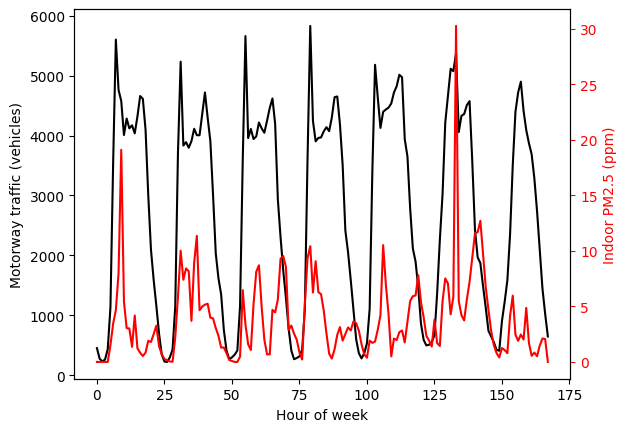

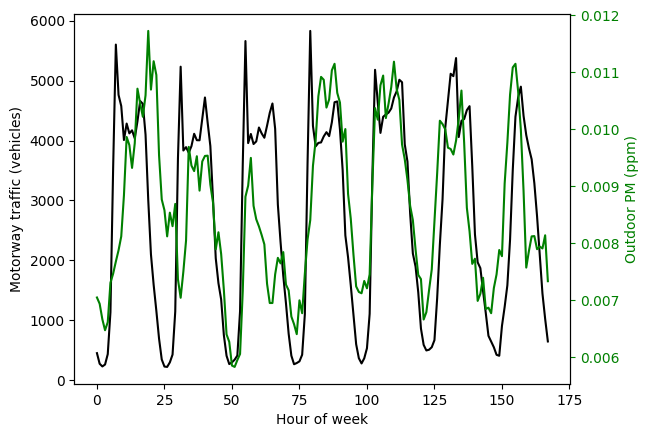

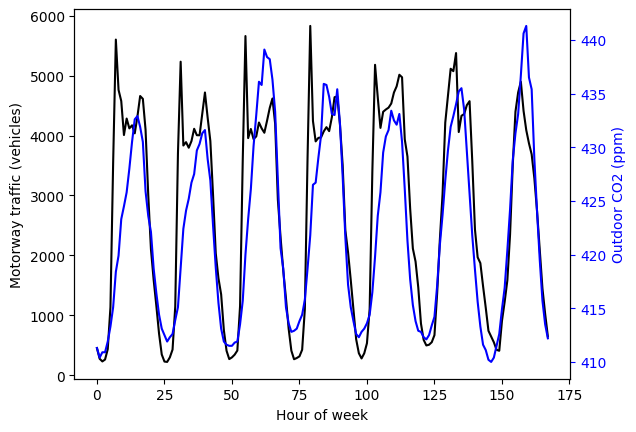

In [149]:
plotter.overlay_plot(df,"M_count","Motorway traffic (vehicles)","PM_25","Indoor PM2.5 (ppm)",['k','r'])
plotter.overlay_plot(df,"M_count","Motorway traffic (vehicles)","out_PM","Outdoor PM (ppm)",['k','g'])
plotter.overlay_plot(df,"M_count","Motorway traffic (vehicles)","out_CO2","Outdoor CO2 (ppm)",['k','b'])

These show correlations, but scatter plots might do it better. If we scatter indoor PM 2.5 vs traffic, we see the weak correlation.

<AxesSubplot: xlabel='M_count', ylabel='PM_25'>

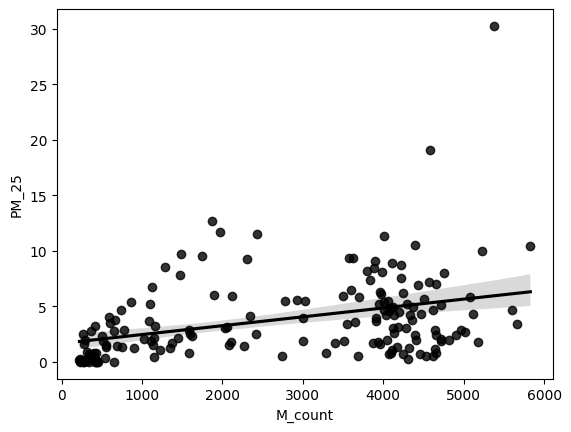

In [150]:
sns.regplot(df,x="M_count",y="PM_25",color="black")

Outdoor PM vs traffic, and outdoor CO2 vs traffic show much stronger correlations.

<AxesSubplot: xlabel='M_count', ylabel='out_PM'>

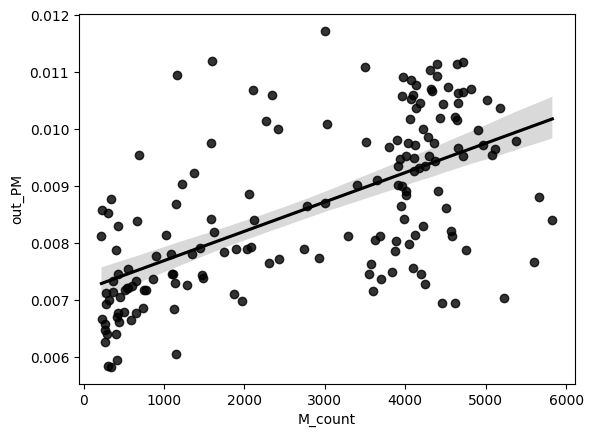

In [151]:
sns.regplot(df,x="M_count",y="out_PM",color="black")

<AxesSubplot: xlabel='M_count', ylabel='out_CO2'>

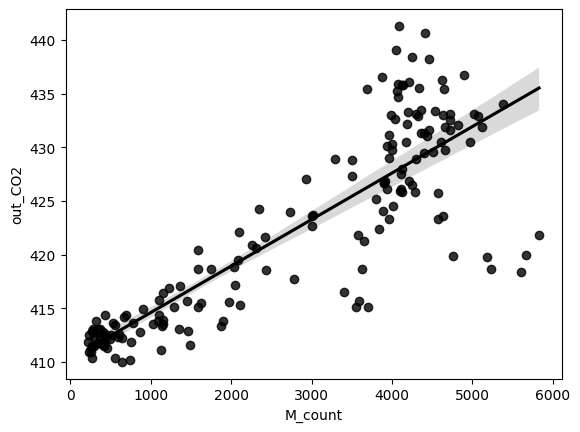

In [152]:
sns.regplot(df,x="M_count",y="out_CO2",color="black")

Indoor PM 2.5 vs outdoor PM: here we have very weak / no correlation. 

<AxesSubplot: xlabel='out_PM', ylabel='PM_25'>

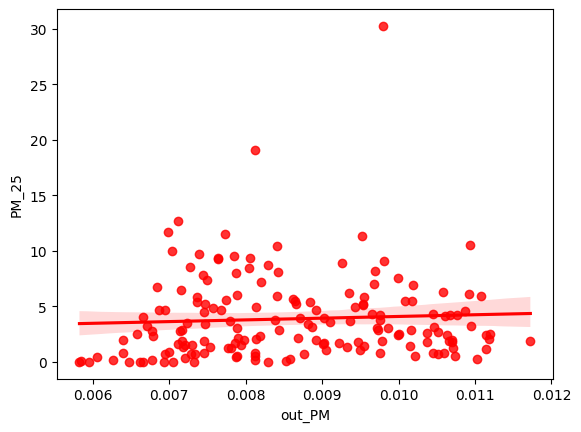

In [153]:
sns.regplot(df,x="out_PM",y="PM_25",color="red")

Could it be that outdoor and indoor PM are just out of phase (e.g. it takes time for particulate matter to move indoors)?

We can check this by cross-correlating the outdoor and indoor PM values with different amounts of lag applied to one time series.

Text(0, 0.5, 'Crosscorr(Outdoor PM, Indoor PM)')

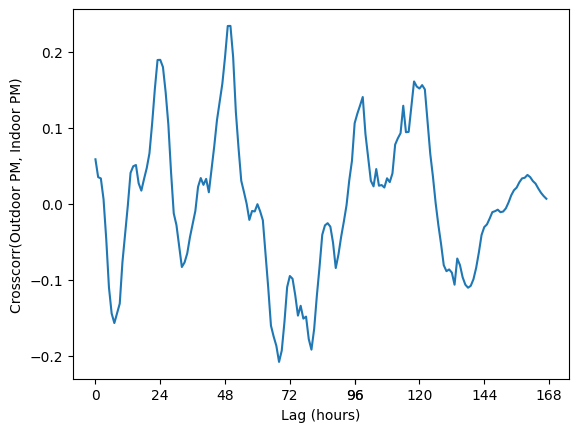

In [154]:
corr_df = pd.Series(sm.tsa.ccf(df["PM_25"],df["out_PM"],adjusted=False))
fig,ax = plt.subplots()
corr_df.plot()
plt.xticks([0,24,48,48+24,48+48,72+24,72+48,72+72,144+24])
ax.set_xlabel("Lag (hours)")
ax.set_ylabel("Crosscorr(Outdoor PM, Indoor PM)")

The plot is daily cyclic, showing maximum correlation values of 0.2. There might be some link here. Getting outdoor air quality data over the same period as indoor air quality data could help in future work.

Some final things that are just interesting. Indoor CO2 vs outdoor CO2 shows a strong negative correlation. The reason for this could be because people tend to stay indoors at night when traffic is low.

<AxesSubplot: xlabel='out_CO2', ylabel='SCD30_CO2'>

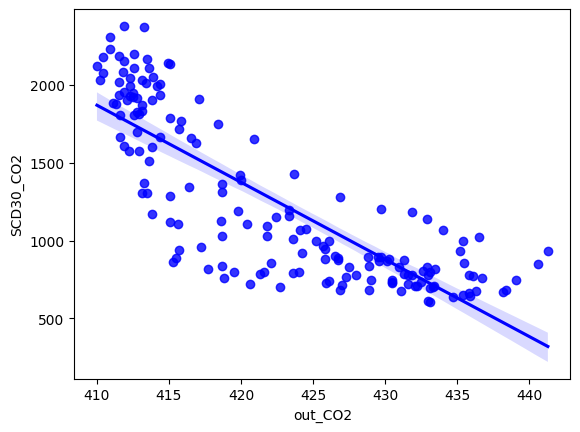

In [155]:
sns.regplot(df,x="out_CO2",y="SCD30_CO2",color="blue")

As the indoor air quality is unmasked, we can use it to calculate the average absolute indoor PM 2.5 levels and compare them against WHO guidelines.

Looks like this location could do with an HEPA filter.

In [156]:
meanval = df["PM_25"].mean() * 1000
print(f"Average PM 2.5 is {np.rint(meanval)} ug/m3. WHO guidelines say aim for annual average of 5 ug/m3")

Average PM 2.5 is 3879.0 ug/m3. WHO guidelines say aim for annual average of 5 ug/m3
